### Import all needed Libraries

In [ ]:
import pandas as pd
import re 
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import seaborn as sns


In [ ]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

<a></a>
## 1. Get the Data

In [ ]:
train = pd.read_csv('/content/train_all_tasks.csv')

In [ ]:
train_task_A = train[['text', 'label_sexist']]

## 2- Discover and visualize the data


In [ ]:
train_task_A.head(3)

,text,label_sexist
0,"Damn, this writing was pretty chaotic",not sexist
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist
2,How the FUCK is this woman still an MP!!!???,not sexist


In [ ]:
print(f"The training set shape is {train_task_A.shape}, {train_task_A.shape[0]} rows and {train_task_A.shape[1]} columns(features).")

The training set shape is (14000, 2), 14000 rows and 2 columns(features).


In [ ]:
train_task_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          14000 non-null  object
 1   label_sexist  14000 non-null  object
dtypes: object(2)
memory usage: 218.9+ KB


In [ ]:
train_task_A.isna().sum()

text            0
label_sexist    0
dtype: int64

In [ ]:
train_task_A.duplicated().sum()

0

As shown there is an unbalance  between the two classes 

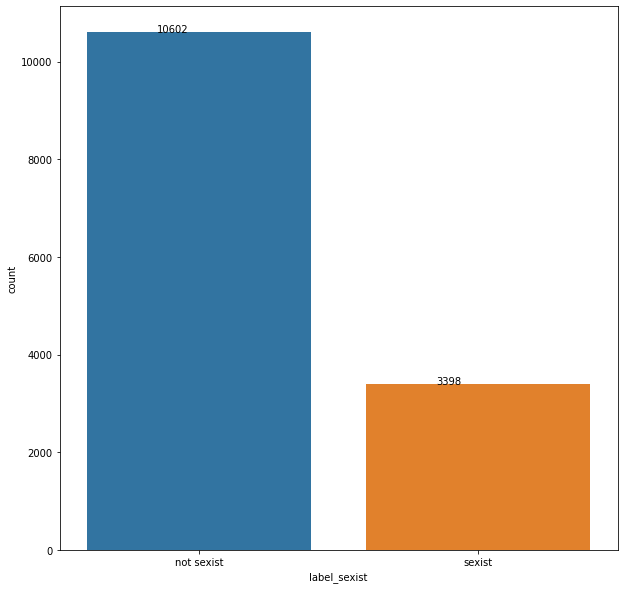

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x=train_task_A["label_sexist"],  data=train_task_A, order = train_task_A["label_sexist"].value_counts().index )
for p, label in zip(ax.patches, train_task_A["label_sexist"].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

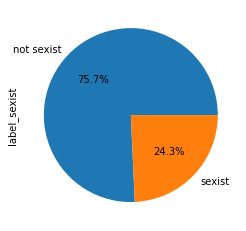

In [ ]:
train_task_A['label_sexist'].value_counts().head(10).plot.pie(autopct='%1.1f%%')


## 3- Prepare the data
###  Data Cleaning 

 
 

In [ ]:
# Encoding the label (not sexist --> 0 , sexist --> 1)

new_label = [0 if x == 'not sexist' else 1 for x in train_task_A['label_sexist']]
train_task_A['label_sexist'] = new_label

<ipython-input-12-038664c6b2c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_task_A['label_sexist'] = new_label


In [ ]:
train_task_A.head(2)

,text,label_sexist
0,"Damn, this writing was pretty chaotic",0
1,"Yeah, and apparently a bunch of misogynistic v...",0


In [ ]:
# to check the functions
def test_cleaning(function, sample):
  print(sample, function(sample), sep='\n')

### Remove Stopwords

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
  return " ".join([word for word in text.split(" ") if word not in stop_words])

test_cleaning(remove_stopwords, train_task_A['text'][0])

Damn, this writing was pretty chaotic
Damn, writing pretty chaotic


### Remove Hashtages

In [ ]:
hashtages = re.compile(pattern="#[\w\d]+")

def remove_hashtages(text):
  return hashtages.sub(repl="", string=text)

test_cleaning(remove_hashtages, '#cjndds akia87#dcld #woh #')

#cjndds akia87#dcld #woh #
 akia87  #


### Remove Mentions

In [ ]:
mensions = re.compile('@\w+')

def remove_mentions(text):
  return mensions.sub(repl="", string=text)

test_cleaning(remove_mentions, 'skon kalkl @dkima;')

skon kalkl @dkima;
skon kalkl ;


### Remove Punctuations Marks

In [ ]:
punctuation_marks = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")

def remove_punch_marks(text):
  return punctuation_marks.sub(repl="", string=text)

test_cleaning(remove_punch_marks, 's; jk > kjnsd n? kknkcdlk 5jbd - ksl/nk #')

s; jk > kjnsd n? kknkcdlk 5jbd - ksl/nk #
s jk  kjnsd n kknkcdlk 5jbd  kslnk 


### Remove HTTP URLs

In [ ]:
def remove_url(text):
  return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)

test_cleaning(remove_url, 'www.slopla.net ksklo;s')

www.slopla.net ksklo;s
  ksklo;s


### Remove Numbers

In [ ]:
numbers = re.compile('\d+')

def remove_numbers(text):
  return numbers.sub(repl="", string=text)

test_cleaning(remove_numbers, 'jndks5kn kndkd199 dijsd5v 22')

jndks5kn kndkd199 dijsd5v 22
jndkskn kndkd dijsdv 


### Remove Multible whitespace

In [ ]:
multiple_whitespace = re.compile('\s{2,}')

def remove_whitespace(text):
  return multiple_whitespace.sub(repl=" ", string=text)

test_cleaning(remove_whitespace, 'xkncd  ;aksdmk ksdc dc  lsdc    lsdclmkdss')

xkncd  ;aksdmk ksdc dc  lsdc    lsdclmkdss
xkncd ;aksdmk ksdc dc lsdc lsdclmkdss


### Remove Emoji

In [ ]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 2.8 MB/s eta 0:00:00


In [ ]:
import demoji
demoji.download_codes()

<ipython-input-23-eb011a9810ad>:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
def remove_emoji(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

test_cleaning(remove_emoji,'Meet the 🙄🙄Goldman Sachs Economist Who 😊Just Lead Germany’s🇩🇪 Far Right to Victory #AfD [URL] 😂')

Meet the 🙄🙄Goldman Sachs Economist Who 😊Just Lead Germany’s🇩🇪 Far Right to Victory #AfD [URL] 😂
Meet the Goldman Sachs Economist Who Just Lead Germany’s Far Right to Victory #AfD [URL] 


### Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer

def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  words_tokenizes = nltk.word_tokenize(text)
  lemmatized_string = " ".join([lemmatizer.lemmatize(word) for word in words_tokenizes])
  return lemmatized_string

test_cleaning(lemmatization, 'fro words in many cars ldfixs') 

fro words in many cars ldfixs
fro word in many car ldfixs


### Stemming

In [ ]:
from nltk.stem import PorterStemmer
def stemmer(text):
    stemr = PorterStemmer()
    words_tokens = nltk.word_tokenize(text)
    stemmer_string = ' '.join([stemr.stem(words) for words in words_tokens])
    return stemmer_string

### Clean all

In [ ]:
def clean_all(text):
  text = remove_url(text)
  # text = remove_hashtages(text)
  text = remove_mentions(text)
  text = remove_punch_marks(text)
  text = remove_numbers(text)
  text = remove_stopwords(text)
  text = remove_whitespace(text)
  text = remove_emoji(text)
  text = lemmatization(text)
  text = text.lower().strip() #lowercase 
  # text = stemmer(text)
  return text

test_cleaning(clean_all, 'How the is this #woman still an MP!!!???')

How the is this #woman still an MP!!!???
how woman still mp


# Save cleaned data for training

In [ ]:
clean_text = []

for text in train_task_A['text']:
  new_data = clean_all(text)
  clean_text.append(new_data)

clean_task_A = pd.DataFrame({'text':clean_text, 'label_sexist':train_task_A['label_sexist']})
clean_task_A

,text,label_sexist
0,damn writing pretty chaotic,0
1,yeah apparently bunch misogynistic virgin one ...,0
2,how fuck woman still mp,0
3,understand know youre right at time i know isn...,0
4,surprized didnt stop rape woman,0
...,...,...
13995,complex like nice chick go bad boy nah nah nah...,1
13996,graphic germany muslim refugee stabbing younge...,0
13997,lol i imagine would simps like doesn ’ t deser...,0
13998,its girl i go date dont kiss first date dont t...,0


In [ ]:
clean_task_A.to_csv('train_cleaned_task_A.csv', index=False)

# loading clean  data and split 

In [ ]:
train = pd.read_csv('/content/train_cleaned_task_A.csv')

In [ ]:
# v=train['text'].apply(str)
# v["tokens"] = train["text"].apply(nltk.word_tokenize)
# v["tokens"].value_counts()[:10].plot(kind='bar')


In [ ]:
X = train['text']
y = train['label_sexist']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#modeling

create table with count result and tfidf result before pos and after pos

###count vectorizer

In [ ]:
# vectorizer = CountVectorizer()
# vector_count_train = vectorizer.fit_transform(X_train.astype(str))
# vector_count_test = vectorizer.transform(X_test.astype(str))

In [ ]:
# print("n_samples: %d, n_features: %d" % vector_count_train.shape)

# **Unigram**

In [ ]:
vectorizer = CountVectorizer()
vector_count_train = vectorizer.fit_transform(X_train.astype(str))
vector_count_test = vectorizer.transform(X_test.astype(str))

In [ ]:
print("n_samples: %d, n_features: %d" % vector_count_train.shape)

n_samples: 12600, n_features: 19613


In [ ]:
f1_scores = []
accuracy = []
models = ['SVM', 'Random Forest', 'GaussianNB', 'LogisticRegression','KNN', 'xgboost']

**SVM**

In [ ]:
#SVM
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(vector_count_train, Y_train)
predictions_SVM = svm_model.predict(vector_count_test)
print(classification_report(Y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1064
           1       0.59      0.50      0.54       336

    accuracy                           0.80      1400
   macro avg       0.72      0.70      0.71      1400
weighted avg       0.79      0.80      0.79      1400



In [ ]:
f1_svm = f1_score(Y_test, predictions_SVM, average='macro')
f1_scores.append(f1_svm)
accuracy.append(accuracy_score(Y_test, predictions_SVM))

**Random** **Forest**

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(vector_count_train, Y_train)
pred_forst = forest_model.predict(vector_count_test)
print(classification_report(Y_test, pred_forst))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1064
           1       0.88      0.35      0.50       336

    accuracy                           0.83      1400
   macro avg       0.85      0.67      0.70      1400
weighted avg       0.84      0.83      0.80      1400



In [ ]:
f1_forst = f1_score(Y_test, pred_forst, average='macro')
f1_scores.append(f1_forst)
accuracy.append(accuracy_score(Y_test, pred_forst))

**GaussianNB**

In [ ]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(vector_count_train.toarray(), Y_train)
pred_NB=gnb.predict(vector_count_test.toarray())
print(classification_report(Y_test, pred_NB))

              precision    recall  f1-score   support

           0       0.79      0.49      0.61      1064
           1       0.26      0.57      0.36       336

    accuracy                           0.51      1400
   macro avg       0.52      0.53      0.48      1400
weighted avg       0.66      0.51      0.55      1400



In [ ]:
f1_nb = f1_score(Y_test, pred_NB, average='macro')
f1_scores.append(f1_nb)
accuracy.append(accuracy_score(Y_test, pred_NB))

**Logistic** **Regressino**

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vector_count_train, Y_train)
pred_clf = clf.predict(vector_count_test)
print(classification_report(Y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1064
           1       0.73      0.43      0.54       336

    accuracy                           0.83      1400
   macro avg       0.79      0.69      0.72      1400
weighted avg       0.81      0.83      0.81      1400



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
f1_logest = f1_score(Y_test, pred_clf, average='macro')
f1_scores.append(f1_logest)
accuracy.append(accuracy_score(Y_test, pred_clf))

**KNN**

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(vector_count_train, Y_train)
pred_knn = knn_model.predict(vector_count_test)
print(classification_report(Y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1064
           1       1.00      0.00      0.01       336

    accuracy                           0.76      1400
   macro avg       0.88      0.50      0.43      1400
weighted avg       0.82      0.76      0.66      1400



In [ ]:
f1_knn = f1_score(Y_test, pred_knn, average='macro')
f1_scores.append(f1_knn)
accuracy.append(accuracy_score(Y_test, pred_knn))

**XGBoost**

In [ ]:
#xgboost
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(vector_count_train, Y_train)
pred_XGB = XGB_model.predict(vector_count_test)
print(classification_report(Y_test, pred_XGB))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1064
           1       0.92      0.33      0.49       336

    accuracy                           0.83      1400
   macro avg       0.87      0.66      0.69      1400
weighted avg       0.85      0.83      0.80      1400



In [ ]:
f1_xgb = f1_score(Y_test, pred_XGB, average='macro')
f1_scores.append(f1_xgb)
accuracy.append(accuracy_score(Y_test, pred_XGB))

### <mark>This Result From Count Vectorizer UNIGRAM <mark>

In [ ]:
compare = pd.DataFrame({'Models' : models , 'macro F1 score' : f1_scores, 'accuracy':accuracy})
compare.sort_values(by='macro F1 score' , ascending=False)

,Models,macro F1 score,accuracy
3,LogisticRegression,0.717696,0.825714
0,SVM,0.705116,0.795714
1,Random Forest,0.699059,0.832143
5,xgboost,0.694584,0.832857
2,GaussianNB,0.483258,0.512143
4,KNN,0.434961,0.760714


#**Bigram**

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2))
vector_count_trainbi = vectorizer.fit_transform(X_train.astype(str))
vector_count_testbi = vectorizer.transform(X_test.astype(str))

In [ ]:
print("n_samples: %d, n_features: %d" % vector_count_trainbi.shape)

n_samples: 12600, n_features: 126401


In [ ]:
f1_scores_bi = []
accuracy_bi = []
models = ['SVM', 'Random Forest', 'GaussianNB', 'LogisticRegression','KNN', 'xgboost']

**SVM**

In [ ]:
#SVM
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(vector_count_trainbi, Y_train)
predictions_SVM = svm_model.predict(vector_count_testbi)
print(classification_report(Y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1064
           1       0.66      0.11      0.19       336

    accuracy                           0.77      1400
   macro avg       0.72      0.55      0.53      1400
weighted avg       0.75      0.77      0.70      1400



In [ ]:
f1_svm = f1_score(Y_test, predictions_SVM, average='macro')
f1_scores_bi.append(f1_svm)
accuracy.append(accuracy_score(Y_test, predictions_SVM))

**Random** **Forest**

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(vector_count_trainbi, Y_train)
pred_forst = forest_model.predict(vector_count_testbi)
print(classification_report(Y_test, pred_forst))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1064
           1       0.89      0.10      0.17       336

    accuracy                           0.78      1400
   macro avg       0.83      0.55      0.52      1400
weighted avg       0.80      0.78      0.70      1400



In [ ]:
f1_forst = f1_score(Y_test, pred_forst, average='macro')
f1_scores_bi.append(f1_forst)
accuracy.append(accuracy_score(Y_test, pred_forst))

**GaussianNB**

In [ ]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(vector_count_trainbi.toarray(), Y_train)
pred_NB=gnb.predict(vector_count_testbi.toarray())
print(classification_report(Y_test, pred_NB))

In [ ]:
f1_nb = f1_score(Y_test, pred_NB, average='macro')
f1_scores_bi.append(f1_nb)
accuracy.append(accuracy_score(Y_test, pred_NB))

**Logistic** **Regressino**

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vector_count_trainbi, Y_train)
pred_clf = clf.predict(vector_count_testbi)
print(classification_report(Y_test, pred_clf))

In [ ]:
f1_logest = f1_score(Y_test, pred_clf, average='macro')
f1_scores_bi.append(f1_logest)
accuracy.append(accuracy_score(Y_test, pred_clf))

**KNN**

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(vector_count_trainbi, Y_train)
pred_knn = knn_model.predict(vector_count_testbi)
print(classification_report(Y_test, pred_knn))

In [ ]:
f1_knn = f1_score(Y_test, pred_knn, average='macro')
f1_scores_bi.append(f1_knn)
accuracy.append(accuracy_score(Y_test, pred_knn))

**XGBoost**

In [ ]:
#xgboost
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(vector_count_trainbi, Y_train)
pred_XGB = XGB_model.predict(vector_count_testbi)
print(classification_report(Y_test, pred_XGB))

In [ ]:
f1_xgb = f1_score(Y_test, pred_XGB, average='macro')
f1_scores_bi.append(f1_xgb)
accuracy.append(accuracy_score(Y_test, pred_XGB))

### <mark>This Result From Count Vectorizer BIGRAM <mark>

In [ ]:
compare = pd.DataFrame({'Models' : models , 'macro F1 score' : f1_scores_bi, 'accuracy':accuracy})
compare.sort_values(by='macro F1 score' , ascending=False)

# TF-IDF

In [ ]:
tfidf_vect = TfidfVectorizer(decode_error = 'ignore')
vectors_train = tfidf_vect.fit_transform(X_train.values.astype('U'))
vectors_test = tfidf_vect.transform(X_test.values.astype('U'))

In [ ]:
print("n_samples: %d, n_features: %d" % vectors_train.shape)

In [ ]:
f1_scores = []
accuracy = []
models = ['SVM', 'Random Forest', 'GaussianNB', 'LogisticRegression','KNN', 'xgboost']

In [ ]:
#SVM
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(vectors_train, Y_train)
predictions_SVM = svm_model.predict(vectors_test)
print(classification_report(Y_test, predictions_SVM))

In [ ]:
f1_svm = f1_score(Y_test, predictions_SVM, average='macro')
f1_scores.append(f1_svm)
accuracy.append(accuracy_score(Y_test, predictions_SVM))

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(vectors_train, Y_train)
pred_forst = forest_model.predict(vectors_test)
print(classification_report(Y_test, pred_forst))

In [ ]:
f1_forst = f1_score(Y_test, pred_forst, average='macro')
f1_scores.append(f1_forst)
accuracy.append(accuracy_score(Y_test, pred_forst))

In [ ]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(vectors_train.toarray(), Y_train)
pred_NB=gnb.predict(vectors_test.toarray())
print(classification_report(Y_test, pred_NB))

In [ ]:
f1_nb = f1_score(Y_test, pred_NB, average='macro')
f1_scores.append(f1_nb)
accuracy.append(accuracy_score(Y_test, pred_NB))

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vectors_train, Y_train)
pred_clf = clf.predict(vectors_test)
print(classification_report(Y_test, pred_clf))

In [ ]:
f1_logest = f1_score(Y_test, pred_clf, average='macro')
f1_scores.append(f1_logest)
accuracy.append(accuracy_score(Y_test, pred_clf))

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(vectors_train, Y_train)
pred_knn = knn_model.predict(vectors_test)
print(classification_report(Y_test, pred_knn))

In [ ]:
f1_knn = f1_score(Y_test, pred_knn, average='macro')
f1_scores.append(f1_knn)
accuracy.append(accuracy_score(Y_test, pred_knn))

In [ ]:
#xgboost
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(vectors_train, Y_train)
pred_XGB = XGB_model.predict(vectors_test)
print(classification_report(Y_test, pred_XGB))

In [ ]:
f1_xgb = f1_score(Y_test, pred_XGB, average='macro')
f1_scores.append(f1_xgb)
accuracy.append(accuracy_score(Y_test, pred_XGB))

### <mark>This Result From TF-IDF Vectorizer <mark>

In [ ]:
compare = pd.DataFrame({'Models' : models , 'macro F1 score' : f1_scores, 'accuracy':accuracy})
compare.sort_values(by='macro F1 score' , ascending=False)

#POS

In [ ]:
# POS tag a sentence
def pos_tag(sentence):
  # Tokenize the sentence
  tokens = nltk.word_tokenize(sentence)

  # POS tag the tokens
  tags = nltk.pos_tag(tokens)

  return tags


In [ ]:
clean_task_A

In [ ]:
pos_text = []

for text in clean_task_A['text']:
  new_data = pos_tag(text)
  pos_text.append(new_data)

pos_data = pd.DataFrame({'text':pos_text, 'label_sexist':train_task_A['label_sexist']})
pos_data

In [ ]:
pos_list = ['CC' , 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP',
            'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

len(pos_list)

In [ ]:
pos_data['text'] = pos_data['text'].apply(lambda x: [tag for word, tag in x if tag in pos_list])

In [ ]:
strings_pos = []
for item in pos_data['text']:
  strings_pos.append(' '.join(item))

In [ ]:
pos_data['text'] = strings_pos

In [ ]:
pos_data.head()

In [ ]:
pos_data.to_csv('pos_data.csv', index=False)

##countvectorizer

In [ ]:
X = pos_data['text']
y = pos_data['label_sexist']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
vectorizer = CountVectorizer()
vector_count_train = vectorizer.fit_transform(X_train.astype(str))
vector_count_test = vectorizer.transform(X_test.astype(str))

In [ ]:
print("n_samples: %d, n_features: %d" % vector_count_train.shape)

In [ ]:
f1_scores = []
accuracy = []
models = ['SVM', 'Random Forest', 'GaussianNB', 'LogisticRegression','KNN', 'xgboost']

##modeling

In [ ]:
#SVM
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(vector_count_train, Y_train)
predictions_SVM = svm_model.predict(vector_count_test)
print(classification_report(Y_test, predictions_SVM))

In [ ]:
f1_svm = f1_score(Y_test, predictions_SVM, average='macro')
f1_scores.append(f1_svm)
accuracy.append(accuracy_score(Y_test, predictions_SVM))

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier()
forest_model.fit(vector_count_train, Y_train)
pred_forst = forest_model.predict(vector_count_test)
print(classification_report(Y_test, pred_forst))

In [ ]:
f1_forst = f1_score(Y_test, pred_forst, average='macro')
f1_scores.append(f1_forst)
accuracy.append(accuracy_score(Y_test, pred_forst))

In [ ]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(vector_count_train.toarray(), Y_train)
pred_NB=gnb.predict(vector_count_test.toarray())
print(classification_report(Y_test, pred_NB))

In [ ]:
f1_nb = f1_score(Y_test, pred_NB, average='macro')
f1_scores.append(f1_nb)
accuracy.append(accuracy_score(Y_test, pred_NB))

In [ ]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vector_count_train, Y_train)
pred_clf = clf.predict(vector_count_test)
print(classification_report(Y_test, pred_clf))

In [ ]:
f1_logest = f1_score(Y_test, pred_clf, average='macro')
f1_scores.append(f1_logest)
accuracy.append(accuracy_score(Y_test, pred_clf))

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(vector_count_train, Y_train)
pred_knn = knn_model.predict(vector_count_test)
print(classification_report(Y_test, pred_knn))

In [ ]:
f1_knn = f1_score(Y_test, pred_knn, average='macro')
f1_scores.append(f1_knn)
accuracy.append(accuracy_score(Y_test, pred_knn))

In [ ]:
#xgboost
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(vector_count_train, Y_train)
pred_XGB = XGB_model.predict(vector_count_test)
print(classification_report(Y_test, pred_XGB))

In [ ]:
f1_xgb = f1_score(Y_test, pred_XGB, average='macro')
f1_scores.append(f1_xgb)
accuracy.append(accuracy_score(Y_test, pred_XGB))

### <mark>this result after using pos tagging and count vectorizer<mark>

In [ ]:
compare = pd.DataFrame({'Models' : models , 'macro F1 score' : f1_scores, 'accuracy':accuracy})
compare.sort_values(by='macro F1 score' , ascending=False)

#trying all model

In [ ]:
# X = train['text']
# y = train['label_sexist']
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# vectorizer = CountVectorizer()
# x_train = vectorizer.fit_transform(X_train.values.astype('U')).todense()
# x_test = vectorizer.transform(X_test.values.astype('U')).todense()

In [ ]:
# !pip3 install lazypredict
# from lazypredict.Supervised import LazyClassifier

In [ ]:
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

In [ ]:
# model, predictions = clf.fit(x_train, x_test, Y_train, Y_test)

In [ ]:
# model